# Teste dos modelos de classificação 

### Criação dos modelos

In [1]:
from nn4_small2_v1 import create_model as create_nn4
from vgg_face import create_model as create_vgg
from facenet import InceptionResNetV1 as create_facenet

Using TensorFlow backend.
/home/italo/eFaceRecon/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/italo/eFaceRecon/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/italo/eFaceRecon/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/italo/eFaceRecon/env/lib/python3.7/sit

In [2]:
nn4_small2 = create_nn4()
vgg_face = create_vgg()
facenet = create_facenet()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Importando os pesos

In [3]:
nn4_small2.load_weights('weights/nn4.small2.v1.h5')
vgg_face.load_weights('weights/vgg_face_weights.h5')
facenet.load_weights('weights/facenet.h5')

### Criação do armazenamento

In [4]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('dataset')

### Alinhamento

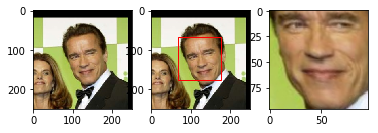

In [5]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[2].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [6]:
def align_image(img, measure):
    return alignment.align(measure, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Extração dos _embedding vectors_

In [7]:
def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

#TODO arrumar tamanhos das imagens para cada rede neural
embedded_nn4 = np.zeros((metadata.shape[0], 128))
embedded_facenet = np.zeros((metadata.shape[0], 128))
embedded_vgg = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img1 = align_image(img, 96)
    img2 = align_image(img, 160)
    img3 = align_image(img, 224)
    # escala os valores RGB para o intervalo [0,1]
    img1 = (img1 / 255. ).astype(np.float32)
    img2 = ((img2 / 127.5) - 1.).astype(np.float32)
    img3 = ((img3 / 127.5) - 1.).astype(np.float32)
    # obtém um embedding vector por imagem
    embedded_nn4[i] = nn4_small2.predict(np.expand_dims(img1, axis=0))[0]
    embedded_facenet[i] = l2_normalize(facenet.predict(np.expand_dims(img2, axis=0))[0,:])
    embedded_vgg[i] = vgg_face.predict(np.expand_dims(img3, axis=0))[0,:]

### Distância dos cossenos e euclidiana

In [8]:
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

### Definição de distância

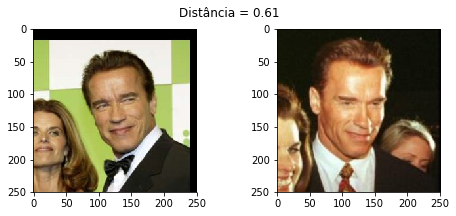

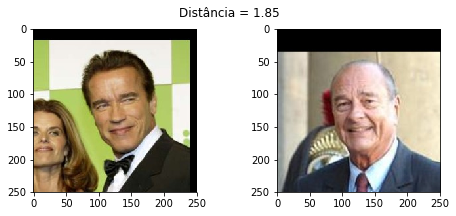

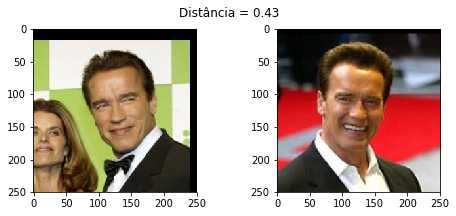

In [9]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2, embedded):
    plt.figure(figsize=(8,3))
    plt.suptitle('Distância = ' + "{:.2f}".format(distance(embedded[idx1], embedded[idx2])))
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3, embedded_nn4)
show_pair(2, 12, embedded_facenet)
show_pair(2, 7, embedded_vgg)

### Codificando os labels

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Transformar as classes em números
y = encoder.transform(targets)

# O conjunto teste não pode conter nenhum elemento desconhecido
train_indexes = np.arange(metadata.shape[0]) % 2 != 0
for index, m in enumerate(metadata):
    if m.name == "desconhecido":
        train_indexes[index] = False
        




### Treino e teste nn4

In [11]:
# Separando em treino e teste
test_indexes = ~train_indexes        
X_train = embedded_nn4[train_indexes]
X_test = embedded_nn4[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

# Construindo os classificadores.
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svm = LinearSVC()
decision_tree = DecisionTreeClassifier(random_state=0)
random_forest = RandomForestClassifier(max_depth=2, random_state=0)
adaboost = AdaBoostClassifier(random_state=0)
naive_bayes = GaussianNB()

knn.fit(X_train, y_train)
svm.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
adaboost.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)



# Classificar como desconhecidas as classes que tiverem throughput muito alto (> 0.57)
def classify_unknowns(y_classifier):
    for n, (x, y_clf_element) in enumerate(zip(X_test, y_classifier)):
        identity = encoder.inverse_transform([y_clf_element])[0]
        class_weights = [embedded_nn4[i] for i in np.arange(metadata.shape[0])[train_indexes] \
                         if metadata[i].name == identity]
        d = np.amin([findCosineDistance(x,w) for w in class_weights])
        if(d > 0.4):
            y_classifier[n] = encoder.transform(["desconhecido"])[0]
    return y_classifier

y_knn = classify_unknowns(knn.predict(X_test))
y_svm = classify_unknowns(svm.predict(X_test))
y_decision_tree = classify_unknowns(decision_tree.predict(X_test))
y_random_forest = classify_unknowns(random_forest.predict(X_test))
y_adaboost = classify_unknowns(adaboost.predict(X_test))
y_naive_bayes = classify_unknowns(naive_bayes.predict(X_test))

# Gerar o relatório de classificação
class_knn = classification_report(y_test, y_knn, target_names=encoder.classes_)
class_svm = classification_report(y_test, y_svm, target_names=encoder.classes_)
class_decision_tree = classification_report(y_test, y_decision_tree, target_names=encoder.classes_)
class_random_forest = classification_report(y_test, y_random_forest, target_names=encoder.classes_)
class_adaboost = classification_report(y_test, y_adaboost, target_names=encoder.classes_)
class_naive_bayes = classification_report(y_test, y_naive_bayes, target_names=encoder.classes_)

print("KNN\n\n" + class_knn)
print("SVM\n\n" + class_svm)
print("Decision Tree\n\n" + class_decision_tree)
print("Random Forest\n\n" + class_random_forest)
print("Adaboost\n\n" + class_adaboost)
print("Naive Bayes\n\n" + class_naive_bayes)

/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KNN

                       precision    recall  f1-score   support

         Ariel_Sharon       1.00      1.00      1.00         5
Arnold_Schwarzenegger       0.83      1.00      0.91         5
         Colin_Powell       0.83      1.00      0.91         5
      Donald_Rumsfeld       1.00      0.60      0.75         5
        George_W_Bush       0.83      1.00      0.91         5
    Gerhard_Schroeder       0.71      1.00      0.83         5
          Hugo_Chavez       1.00      1.00      1.00         5
       Jacques_Chirac       1.00      1.00      1.00         5
           Tony_Blair       0.80      0.80      0.80         5
       Vladimir_Putin       1.00      1.00      1.00         5
         desconhecido       1.00      0.70      0.82        10

            micro avg       0.90      0.90      0.90        60
            macro avg       0.91      0.92      0.90        60
         weighted avg       0.92      0.90      0.90        60

SVM

                       precision    recall

/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Treino e teste Facenet

In [12]:
# Separando em treino e teste
test_indexes = ~train_indexes        
X_train = embedded_facenet[train_indexes]
X_test = embedded_facenet[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

# Construindo os classificadores.
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svm = LinearSVC()
decision_tree = DecisionTreeClassifier(random_state=0)
random_forest = RandomForestClassifier(max_depth=2, random_state=0)
adaboost = AdaBoostClassifier(random_state=0)
naive_bayes = GaussianNB()

knn.fit(X_train, y_train)
svm.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
adaboost.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)



# Classificar como desconhecidas as classes que tiverem throughput muito alto (> 0.57)
def classify_unknowns(y_classifier):
    for n, (x, y_clf_element) in enumerate(zip(X_test, y_classifier)):
        identity = encoder.inverse_transform([y_clf_element])[0]
        class_weights = [embedded_facenet[i] for i in np.arange(metadata.shape[0])[train_indexes] \
                         if metadata[i].name == identity]
        d = np.amin([findCosineDistance(x,w) for w in class_weights])
        if(d > 0.55):
            y_classifier[n] = encoder.transform(["desconhecido"])[0]
    return y_classifier

y_knn = classify_unknowns(knn.predict(X_test))
y_svm = classify_unknowns(svm.predict(X_test))
y_decision_tree = classify_unknowns(decision_tree.predict(X_test))
y_random_forest = classify_unknowns(random_forest.predict(X_test))
y_adaboost = classify_unknowns(adaboost.predict(X_test))
y_naive_bayes = classify_unknowns(naive_bayes.predict(X_test))

# Gerar o relatório de classificação
class_knn = classification_report(y_test, y_knn, target_names=encoder.classes_)
class_svm = classification_report(y_test, y_svm, target_names=encoder.classes_)
class_decision_tree = classification_report(y_test, y_decision_tree, target_names=encoder.classes_)
class_random_forest = classification_report(y_test, y_random_forest, target_names=encoder.classes_)
class_adaboost = classification_report(y_test, y_adaboost, target_names=encoder.classes_)
class_naive_bayes = classification_report(y_test, y_naive_bayes, target_names=encoder.classes_)

print("KNN\n\n" + class_knn)
print("SVM\n\n" + class_svm)
print("Decision Tree\n\n" + class_decision_tree)
print("Random Forest\n\n" + class_random_forest)
print("Adaboost\n\n" + class_adaboost)
print("Naive Bayes\n\n" + class_naive_bayes)

/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KNN

                       precision    recall  f1-score   support

         Ariel_Sharon       1.00      1.00      1.00         5
Arnold_Schwarzenegger       1.00      0.60      0.75         5
         Colin_Powell       0.83      1.00      0.91         5
      Donald_Rumsfeld       0.75      0.60      0.67         5
        George_W_Bush       0.80      0.80      0.80         5
    Gerhard_Schroeder       0.50      1.00      0.67         5
          Hugo_Chavez       1.00      1.00      1.00         5
       Jacques_Chirac       1.00      1.00      1.00         5
           Tony_Blair       0.80      0.80      0.80         5
       Vladimir_Putin       1.00      1.00      1.00         5
         desconhecido       0.86      0.60      0.71        10

            micro avg       0.83      0.83      0.83        60
            macro avg       0.87      0.85      0.85        60
         weighted avg       0.87      0.83      0.83        60

SVM

                       precision    recall

/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Treino e teste VGG Faces

In [13]:
# Separando em treino e teste
test_indexes = ~train_indexes        
X_train = embedded_vgg[train_indexes]
X_test = embedded_vgg[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

# Construindo os classificadores.
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svm = LinearSVC()
decision_tree = DecisionTreeClassifier(random_state=0)
random_forest = RandomForestClassifier(max_depth=2, random_state=0)
adaboost = AdaBoostClassifier(random_state=0)
naive_bayes = GaussianNB()

knn.fit(X_train, y_train)
svm.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
adaboost.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)



# Classificar como desconhecidas as classes que tiverem throughput muito alto (> 0.57)
def classify_unknowns(y_classifier):
    for n, (x, y_clf_element) in enumerate(zip(X_test, y_classifier)):
        identity = encoder.inverse_transform([y_clf_element])[0]
        class_weights = [embedded_vgg[i] for i in np.arange(metadata.shape[0])[train_indexes] \
                         if metadata[i].name == identity]
        d = np.amin([findCosineDistance(x,w) for w in class_weights])
        if(d > 0.42):
            y_classifier[n] = encoder.transform(["desconhecido"])[0]
    return y_classifier

y_knn = classify_unknowns(knn.predict(X_test))
y_svm = classify_unknowns(svm.predict(X_test))
y_decision_tree = classify_unknowns(decision_tree.predict(X_test))
y_random_forest = classify_unknowns(random_forest.predict(X_test))
y_adaboost = classify_unknowns(adaboost.predict(X_test))
y_naive_bayes = classify_unknowns(naive_bayes.predict(X_test))

# Gerar o relatório de classificação
class_knn = classification_report(y_test, y_knn, target_names=encoder.classes_)
class_svm = classification_report(y_test, y_svm, target_names=encoder.classes_)
class_decision_tree = classification_report(y_test, y_decision_tree, target_names=encoder.classes_)
class_random_forest = classification_report(y_test, y_random_forest, target_names=encoder.classes_)
class_adaboost = classification_report(y_test, y_adaboost, target_names=encoder.classes_)
class_naive_bayes = classification_report(y_test, y_naive_bayes, target_names=encoder.classes_)

print("KNN\n\n" + class_knn)
print("SVM\n\n" + class_svm)
print("Decision Tree\n\n" + class_decision_tree)
print("Random Forest\n\n" + class_random_forest)
print("Adaboost\n\n" + class_adaboost)
print("Naive Bayes\n\n" + class_naive_bayes)

/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KNN

                       precision    recall  f1-score   support

         Ariel_Sharon       0.71      1.00      0.83         5
Arnold_Schwarzenegger       1.00      0.80      0.89         5
         Colin_Powell       1.00      1.00      1.00         5
      Donald_Rumsfeld       1.00      0.40      0.57         5
        George_W_Bush       0.67      0.80      0.73         5
    Gerhard_Schroeder       0.75      0.60      0.67         5
          Hugo_Chavez       1.00      1.00      1.00         5
       Jacques_Chirac       0.43      0.60      0.50         5
           Tony_Blair       0.44      0.80      0.57         5
       Vladimir_Putin       0.83      1.00      0.91         5
         desconhecido       0.80      0.40      0.53        10

            micro avg       0.73      0.73      0.73        60
            macro avg       0.79      0.76      0.75        60
         weighted avg       0.79      0.73      0.73        60

SVM

                       precision    recall

/home/italo/eFaceRecon/env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
